# BC3 Clustering customers

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

April 2022

https://github.com/fpontejos/bc3


## Initial Setup

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections

warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import is_color_like
import matplotlib.cm as cm

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans



In [3]:
COLORS = ['#e06666', '#e88b81', '#f0ad9a', '#f8ceb2', '#ffeeca', '#c6cfbf', '#8fb0ae', '#58919d', '#20718b']

CAT_COLORS = ['#20718b', '#7DB082', '#FAEC73', '#ECA052', '#e06666']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#e06666', '#e68d8d', '#ebb1b1', '#efd3d3', '#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#e06666', '#20718b']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_PATH = '../data/'


In [4]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


In [5]:
## Function to plot histograms of numeric features for specified dfframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables", bins=10):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0], bins=bins)
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [6]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

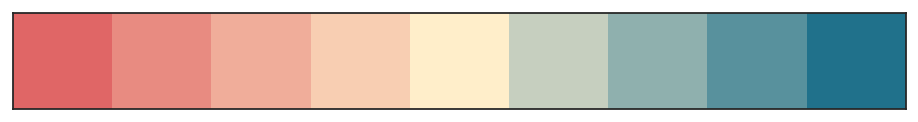

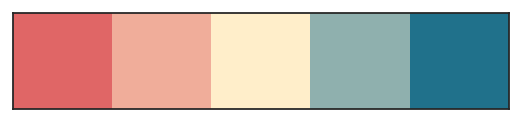

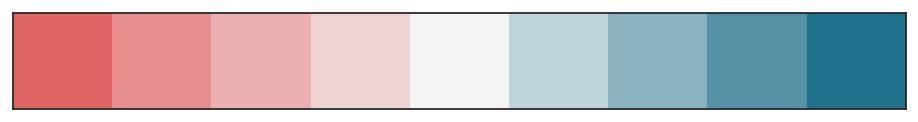

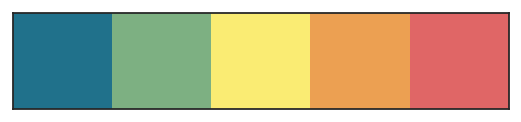

In [7]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load data

In [8]:
df = pd.read_csv(DATA_PATH + "customer_agg.csv", index_col='CustomerID')

df_orig = df.copy()

feats = df.columns

In [9]:
def plot_labels(df, labels, title='Data Visualization', label_map=None):    
    l = labels
    lmap = {}
    
    if label_map:
        l2 = labels.copy()
        for i in range(len(label_map)):
            lmap[label_map[i]] = i
        l = l2.replace(lmap)
        
    fig, ax = plt.subplots(figsize=(10,10))

    scatter = ax.scatter(x=df[0], y=df[1], c=l, cmap=UMP_CMAP,\
               s=2, marker="o", alpha=.5, label='Final Clusters')

    ncol = len(labels.unique().tolist())
    ncol = round(ncol/2) + 1 if ncol > 7 else ncol
    if label_map == None:
        legend1 = ax.legend(*scatter.legend_elements(),
                        bbox_to_anchor=(.5,1,.5,1), loc="lower left", frameon=False,
                        mode='expand', borderaxespad=0, ncol=ncol,
                       )


    ax.set_xticklabels('')
    ax.set_yticklabels('')
    plt.title(title, loc='left')
    
    if SAVE_PLOTS:
        save_fig(title, fig)

    plt.show()

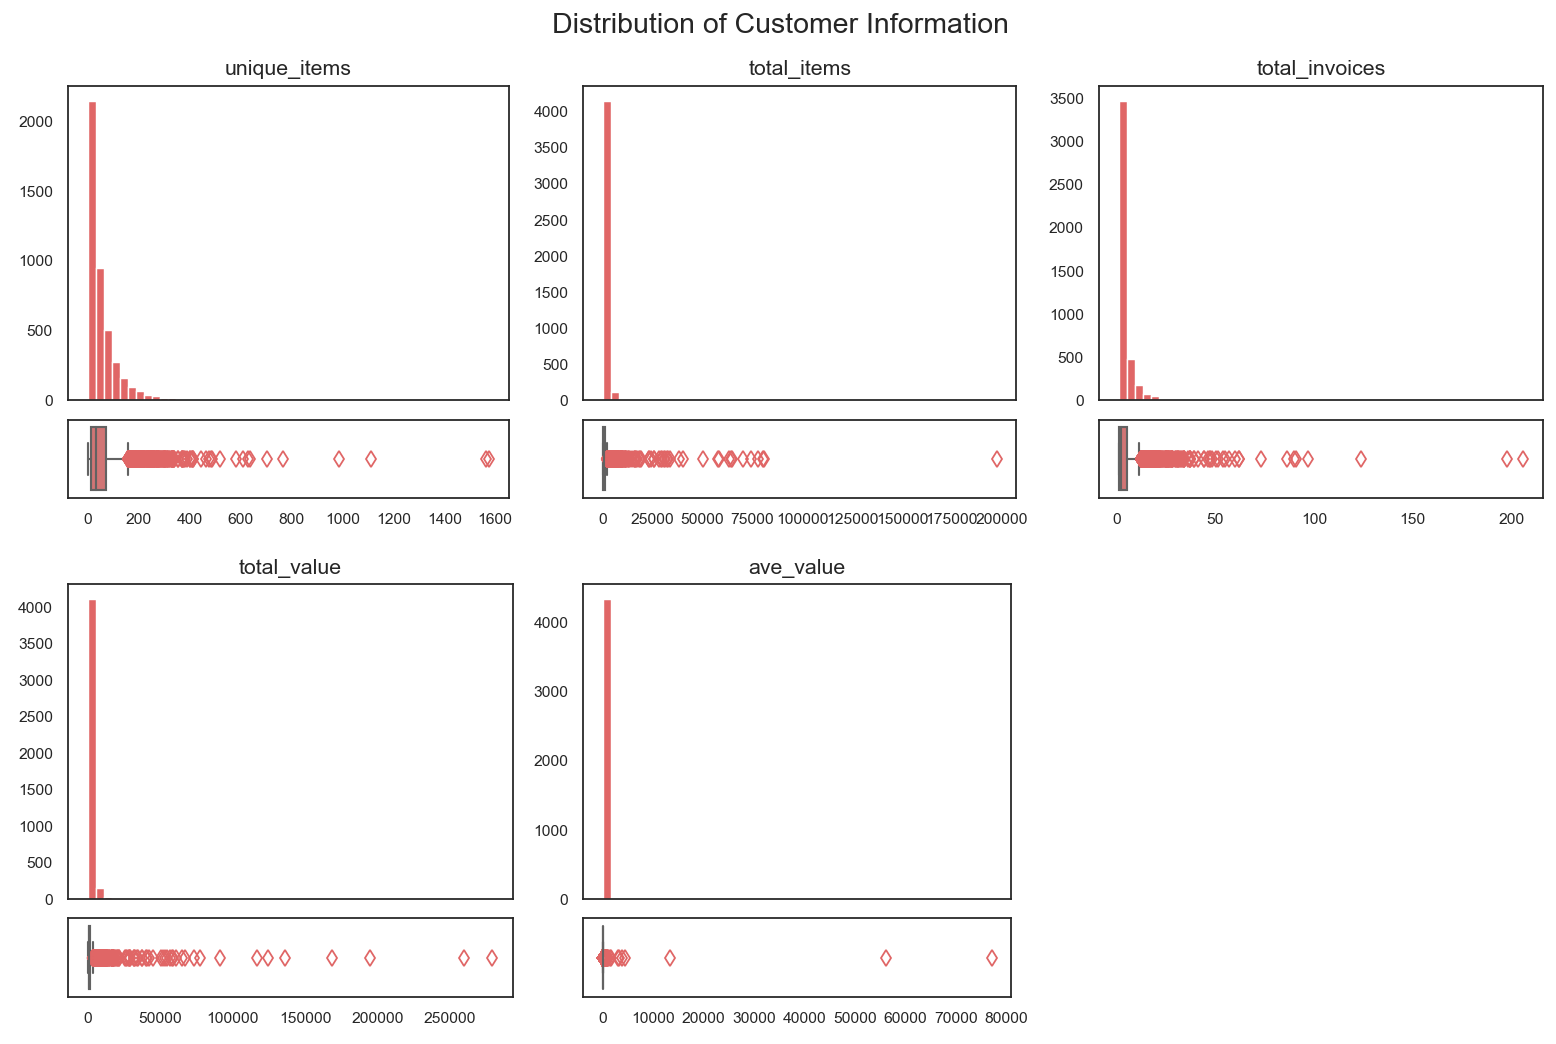

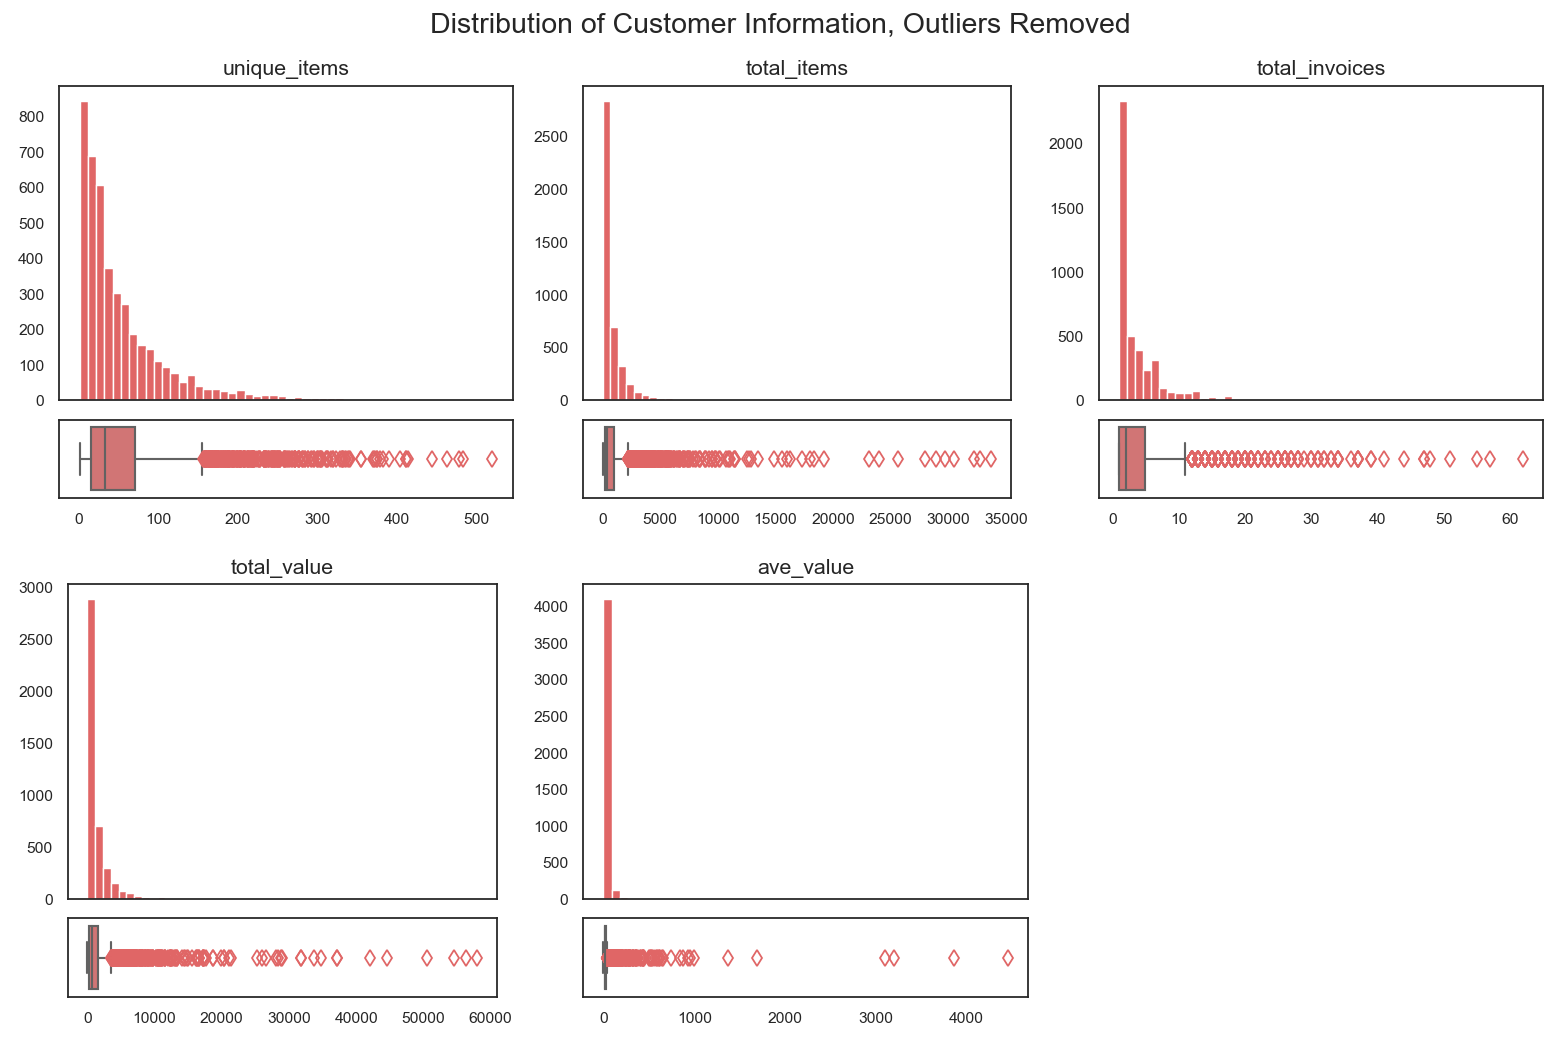

In [10]:
df_ = df.loc[(df['ave_value']<10000) &
            (df['total_items']<40000) &
            (df['unique_items']<600) &
            (df['total_invoices']<70) 
           ]

plot_histograms_boxplots(df, df.columns, rows=2, title ="Distribution of Customer Information", bins=50)
plot_histograms_boxplots(df_, df_.columns, rows=2, title ="Distribution of Customer Information, Outliers Removed", bins=50)


In [11]:
print(df_.shape)
print(df.shape)
(1 - (df_.shape[0]/df.shape[0]))*100

(4313, 5)
(4335, 5)


0.5074971164936604

In [12]:
scaler    = StandardScaler().fit(df_[df_.columns])
scaled_data = scaler.transform(df[df.columns])
merged_data = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
merged_data.describe()

,unique_items,total_items,total_invoices,total_value,ave_value
count,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000
mean,0.037934,0.128349,0.059909,0.140341,0.261795
std,1.250480,2.518903,1.520509,2.723826,11.229792
min,-0.869976,-0.465858,-0.586246,-0.477644,-0.257972
25%,-0.641822,-0.386589,-0.586246,-0.384242,-0.164341
50%,-0.348481,-0.277407,-0.387122,-0.273341,-0.123698
75%,0.287091,0.028451,0.210251,0.021300,-0.069776
max,24.781061,97.956631,40.234222,84.889514,589.931675


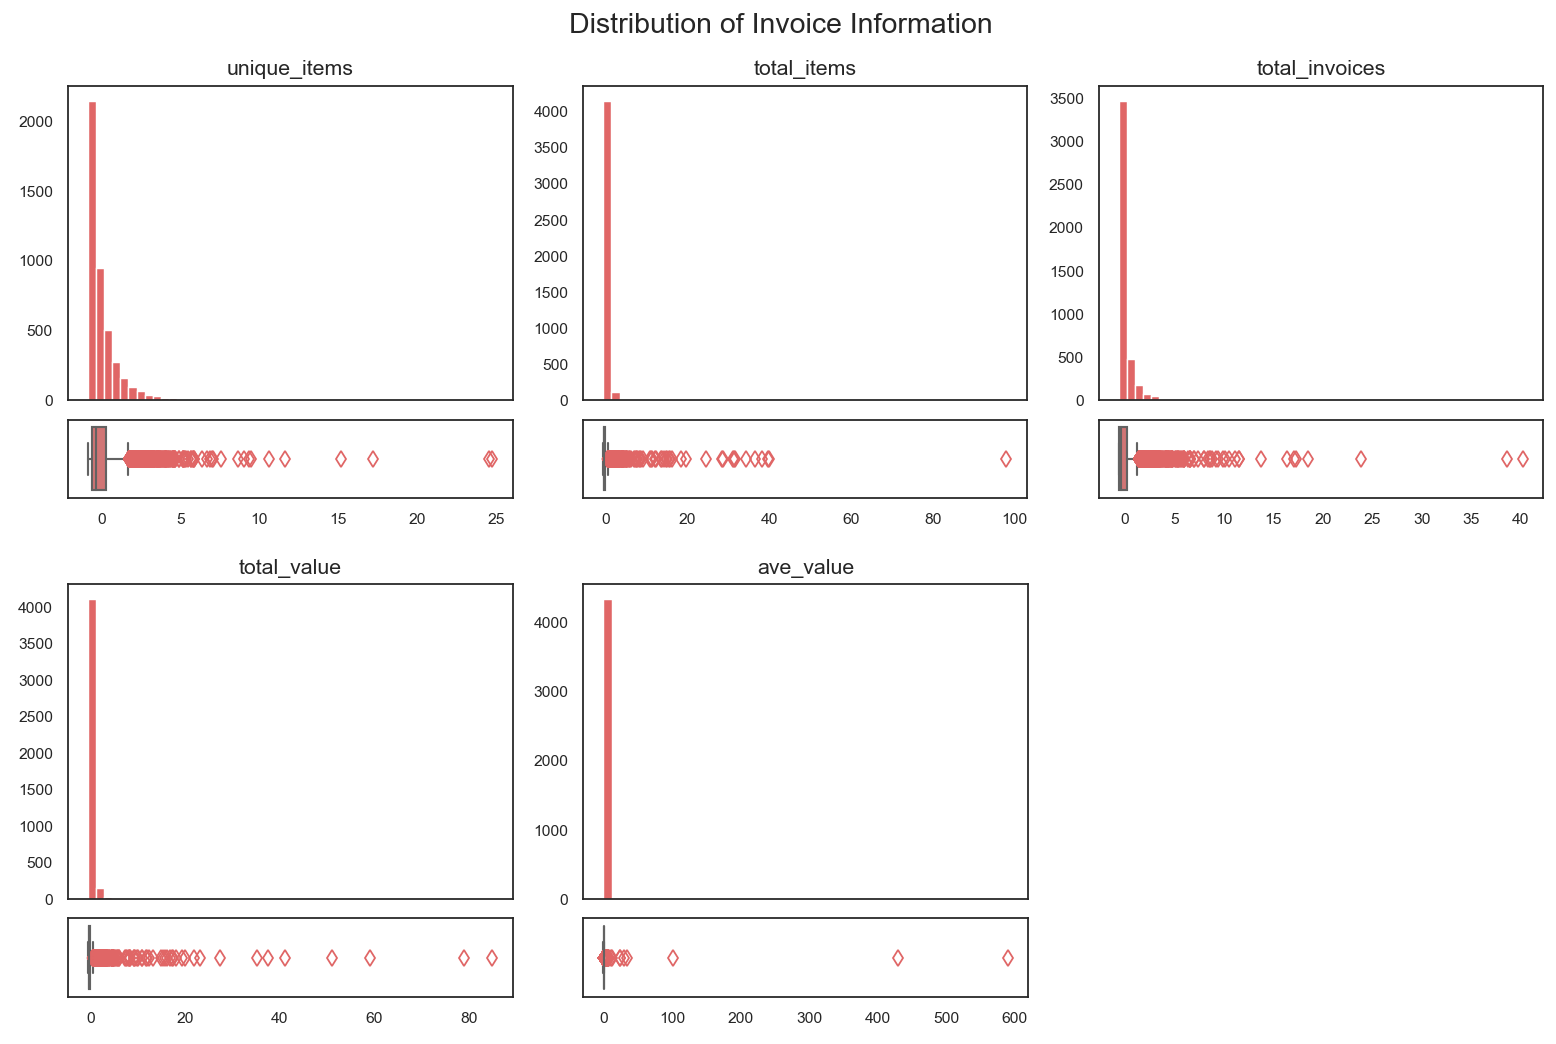

In [13]:
plot_histograms_boxplots(merged_data, df.columns, rows=2, title ="Distribution of Invoice Information", bins=50)


In [14]:
umap_data = umap.UMAP(random_state=RANDOM_STATE, metric='euclidean', min_dist=0.01, 
                      n_neighbors=30, n_components=2)\
                    .fit_transform(scaled_data)

umap_data_df = pd.DataFrame(umap_data, index=df.index)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Kmeans

In [15]:
customer_kmeans = KMeans(n_clusters=2, init='k-means++', 
                         max_iter=1000, random_state=RANDOM_STATE)

umap_data_df['kmeans'] = customer_kmeans.fit_predict(umap_data_df)


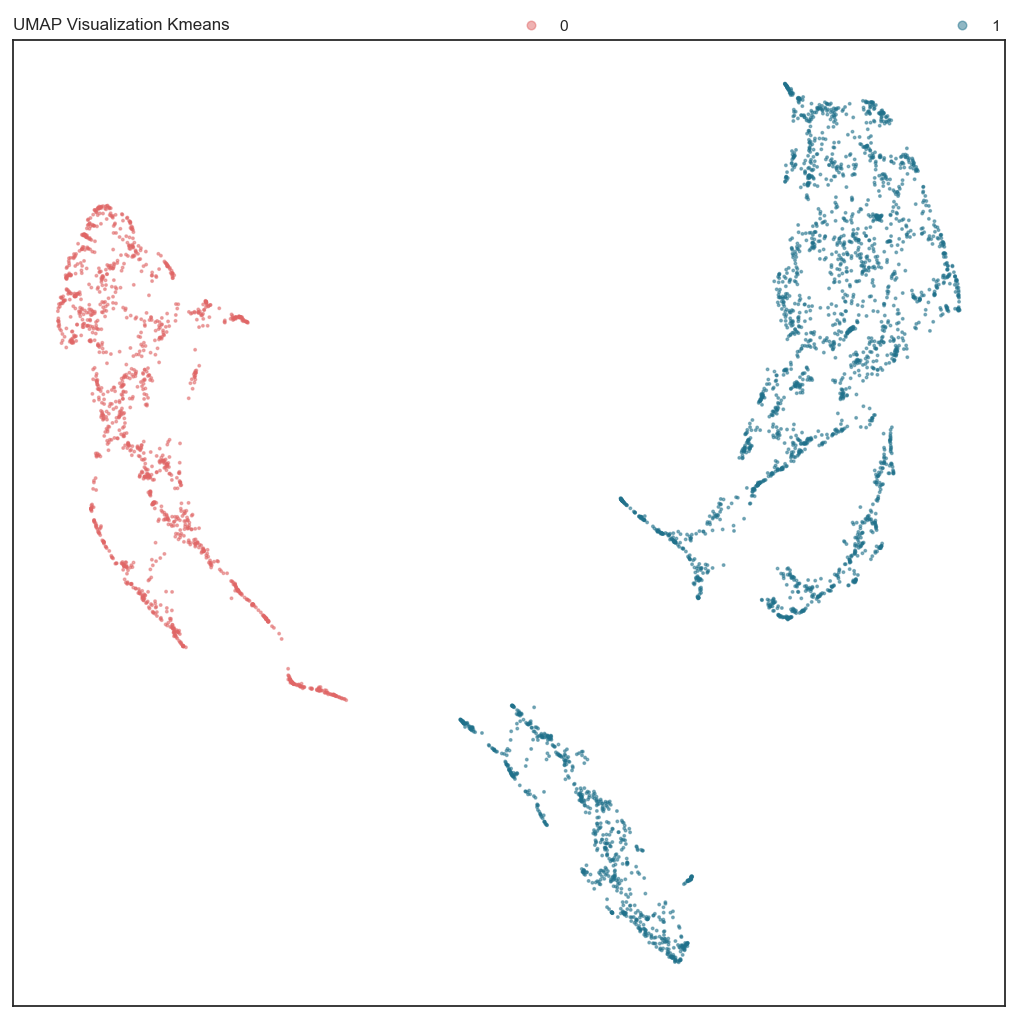

In [16]:
plot_labels(umap_data_df.iloc[:,0:2], umap_data_df['kmeans'], 'UMAP Visualization Kmeans')

In [17]:
merged_data['labels'] = umap_data_df['kmeans']
df['labels'] = umap_data_df['kmeans']
#merged_data

In [18]:
def show_cluster_heatmap(df, label1, cols, title='Heatmap of Cluster Means', cluster_labels=[]):
    fig, ax = plt.subplots(constrained_layout=True , figsize=(4,4))
    
    label_counts = df.groupby(label1)[label1].count()
    df_i = df.groupby(label1)[cols].mean().index
    
    
    if len(cluster_labels) == 0:
        cluster_labels = df_i
    
    xticks = [(str(cluster_labels[l]) + "\n" + str(label_counts[l])) for l in range(len(label_counts))]
    
    sns.heatmap(df.groupby(label1)[cols].mean().loc[df_i,:].T, \
            cmap=DIV_CMAP, xticklabels=xticks, annot=True, fmt='.2f', annot_kws={"fontsize":14})

    k = len(df[label1].unique().tolist())
    
    ax.set_xlabel(('Cluster Sizes and Labels, K = '+str(k)))
    
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10, rotation=0)
    
    fig.suptitle(title, y=1.1, fontsize=20)
    
    if SAVE_PLOTS:
        save_fig(title, fig)
    
    plt.show()


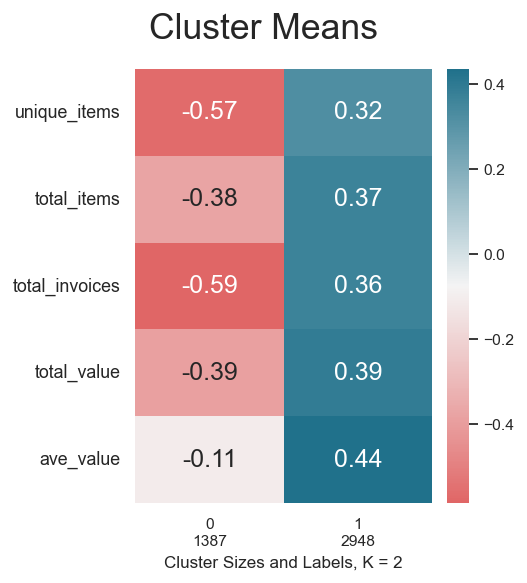

In [19]:
show_cluster_heatmap(merged_data, 'labels', feats, 'Cluster Means')

In [20]:
## Function to plot histograms of numeric features for specified dataframe
def plot_final_histo_box(df, features, col, title = "Final Clusters: Relative Distributions of Numeric Variables"):
    if SHOW_PLOTS:
        
        rows = sorted(df[col].unique().tolist())
        
        merged_labels_map = {}
        for i in range(len(rows)):
            merged_labels_map[rows[i]] = i
    
        cols = range(len(features))

        fig = plt.figure(figsize=(12,9), \
                         constrained_layout=True)
        
        
        
        subfigs = fig.subfigures(len(rows), len(features), facecolor='#fdfdfd')
        for c in cols: # feats
            for r in rows: # clusters
                ri = merged_labels_map[r]
                color = UMP_COLORS[ri]
                
                df_ = df.loc[df[col]==r,[features[c]]]
                axs = subfigs[ri][c].subplots(2, 1, sharex='col', \
                                gridspec_kw={'height_ratios': [4,1]})
                axs[0].hist(df_, color=color)
                #axs[0].set_xlim(0,1)
                axs[0].set_title(features[c], y=1, fontsize=10)
                
                sns.boxplot(x=df_[features[c]], ax=axs[1], color=color)
                axs[1].set_xlabel(None)
                
                if c==0:
                    csize = ' [ ' + str(len(df_)) + ' ]'
                    axs[0].set_ylabel('Cluster '+ str(int(r))+csize)
        
        plt.suptitle(title, fontsize=24)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")
        


In [21]:
## Function to plot histograms of numeric features for specified dataframe
def plot_final_histo_box(df, features, col, title = "Final Clusters: Relative Distributions of Numeric Variables"):
    if SHOW_PLOTS:
        
        rows = sorted(df[col].astype(int).unique().tolist())
        
        merged_labels_map = {}
        for i in range(len(rows)):
            merged_labels_map[rows[i]] = i
    
        cols = range(len(features))

        fig, ax = plt.subplots(4,len(features), figsize=(11,7), \
                         constrained_layout=True,
                         gridspec_kw={'height_ratios': [3, 1, 3,1]},
                         #sharex='col',
                        )
        subi_ = 2
        for r in rows:
            
            for c in cols:
                ## hist
                ax_ = ax[(r*subi_) + 0][c] #.set_xlabel(str((r*subi_)+0)+'hist')
                
                df_ = df.loc[df[col]==r,[features[c]]]
                ax_.hist(df_, color=UMP_COLORS[r],)
                
                ## box
                ax_ = ax[(r*subi_) + 1][c] #.set_xlabel(str((r*subi_)+1)+'box')
                sns.boxplot(x=df_[features[c]], ax=ax_, color=UMP_COLORS[r])
                    
        
                if c==0:
                    csize = ' [ ' + str(len(df_)) + ' ]'
                    
                    ax[(r*subi_) + 0][0].set_ylabel('Cluster '+ str(int(r))+csize)
        
        #subfigs = fig.subfigures(len(rows), len(features), facecolor='#fdfdfd')
        
        
        
        
        plt.suptitle(title, fontsize=24)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")
        


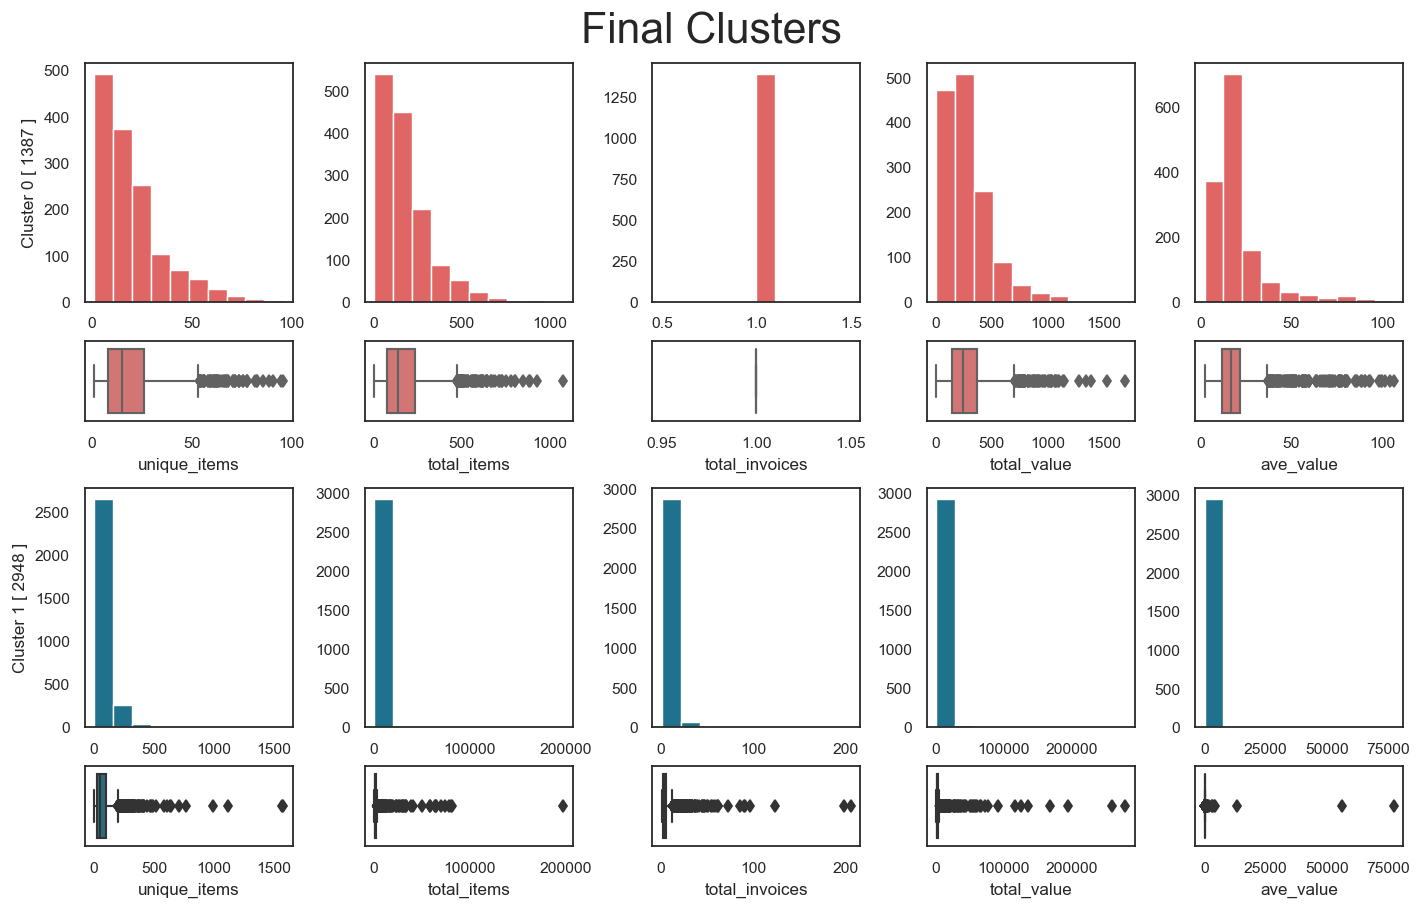

In [22]:
plot_final_histo_box(df, feats, 'labels', title='Final Clusters')


## Export Labels

In [23]:
df.loc[df['labels']==1,['labels']] = 'Wholesale'
df.loc[df['labels']==0,['labels']] = 'Retail'
df.rename(columns={'labels': 'Customer Type'}, inplace=True)


In [28]:
df.loc[:, ['Customer Type']].to_csv(DATA_PATH + 'customer_types.csv')


In [25]:
df

,unique_items,total_items,total_invoices,total_value,ave_value,Customer Type
CustomerID,,,,,,
12346,1,74215,1,77183.60,77183.600000,Wholesale
12347,86,2458,7,4310.00,23.681319,Wholesale
12348,21,2332,4,1437.24,53.231111,Wholesale
12349,69,630,1,1457.55,20.243750,Wholesale
12350,16,196,1,294.40,18.400000,Retail
...,...,...,...,...,...,...
18280,9,45,1,180.60,18.060000,Retail
18281,7,54,1,80.82,11.545714,Retail
18282,12,103,2,178.05,14.837500,Wholesale


In [26]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2_(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

In [27]:
r2_(umap_data_df.iloc[:,0:2],df['Customer Type'])

0.6665311083135264